# Part 1 : Sampling and filtering

In this part of the lab work, we are going to look at the frequency content of images, and certain filtering operations which which we can carry out.

__Note__ : in this part of the TP, we will avoid using plt.imshow(). Indeed, if you use imshow to display an image, it will change the resolution of this image. Since we are going to be looking at aliasing effects (which is induced precisely by changing resolution), it is better to write the output to an image file and view it in a separate program.

First, let us load the necessary packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color
from scipy import signal
from skimage.morphology import skeletonize

is_colab= False

The last package will help us to carry out the convolution operation. Let's define two functions to read and write and image :

In [2]:
def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))

In [3]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/boston.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

(600, 600)

## Frequency content

Firstly, we are going to inspect the frequency content of the image. Write a function to display the magnitude of the spectrum of the image. For this, you can use the following functions

- ``np.fft.fft2``
- ``np.fft.fftshift``

The first calculates the 2D Fast Fourier Transform of the image. The second centres the spectrum, such that the 0 frequency is centred in the image. Otherwise the 0 point is set at the top left, which is not very conveniant for visualisation.

A final note. It is often the case that the 0 frequency is of much larger amplitude than the other frequencies. Therefore, we often visualise log(1+spectrum_magnitude) rather than spectrum_magnitude itself.

Write this function ``display_spectrum`` now.

In [4]:
def display_spectrum(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    img_out = np.log(1+np.abs(fshift))
    
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.title('Original image')
    plt.subplot(122)
    plt.imshow(img_out, cmap='gray')
    plt.title('Spectrum')
    plt.show()
    return img_out


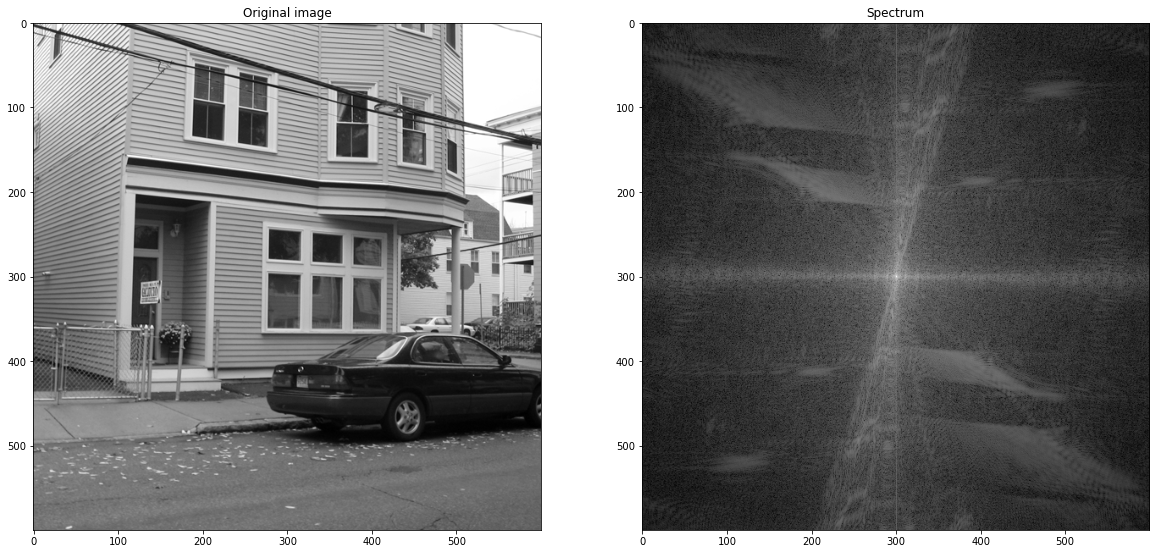

In [5]:
a = display_spectrum(img_gray)

In [6]:
write_image(a,file_name+'_spectrum_Tom.png')

__Question__ 1.1 : What do you observe in the frequency domain ? What is your interpretation of this image ?

<div class="alert alert-block alert-success">
Answer : 

- First there is like an horizontal line in the spectrum, corresponding to all the vertical lines in the input image.
- Second, we can see high intensity in the center of the spectrum.
- Third, there is a pretty vertical line, corresponding to the horizontal lines in the structure of the image . (For instance, the car, the structure of the house,...


## Subsampling and aliasing

We are now going to carry out a ''direct'' subsampling (also known as a ''nearest neighbours'' subsampling of a factor $\delta$, that is to say we simply take one out of every two pixels. Fill in the following function to do this :

In [7]:
def nn_subsampling(img_in,delta):
    im= img_in[0:600:delta,0:600:delta]
    return im

In [8]:
nn_subsampling(img_gray,2).shape

(300, 300)

We write the subsampled image, with subsampling step $\delta = 2$

In [9]:
delta = 2
image_small = nn_subsampling(img_gray,delta)
write_image(image_small, file_name+'_subsampled.png')

__Question__ 1.2 What do you notice about the image ? Where is the aliasing taking place ? Why is it taking place in these specific regions ?

<div class="alert alert-block alert-success">
    Answer :

The new image seems to be more blur.
By doing this subsampling, we can see there is the aliasing phenomenon, due to the frequences.
This is more visible on the structure house because of the horizontal lines, for the high frequences.
This is not visible for the road, or the car for instance who don't show high frequences.

We have seen two different methods of filtering an image before subsampling to remove high frequencies :

- Ideal low-pass filter
- Gaussian filter

We recall that the convolution operation, which defines a filter, can be carried out either in the time domain or the frequency domain.

Write a function which filters an input image via the frequency domain, with the input filter $f_hat$ defined in the frequency domain. The output ``img_out`` should be in the spatial domain. You can use the ``np.fft.ifft2`` function to carry out the inverse Fourier transform. Make sure to take the __real__ part of the output image (``np.real``).

In [10]:
def filter_image(img,f_hat):
    
    img = np.fft.fft2(img)
    img = np.fft.fftshift(img)
    img_f = img * f_hat
    img_f = np.fft.ifftshift(img_f)
    img_f = np.fft.ifft2(img_f)
    img_out = np.real(img_f)

    return(img_out)

Now, create a function ``ideal_low_pass_filter`` which returns an ideal low-pass filter $\hat{h}$ in the frequency domain. Note : by definition the 0 frequency is at the top left point of the image. To convert it to this format, you can use the ``np.fft.ifftshift`` function (which inverses the fftshift). In the ''centred'' representation of the frequency, for an image of even size $n=2a$, the 0 frequency position is located at position $a$ (where 0 is the first position).

Hint : the distance transform ``scipy.ndimage.morphology.distance_transform_edt`` can be useful here.

In [11]:
def ideal_low_pass_filter(img_shape,nu_0):
    
    f_hat = np.zeros(img_shape)
    nu_0 = (len(f_hat)/2)*nu_0
    center = np.array(f_hat.shape)//2.0
    
    for i in range(len(f_hat)):
        for j in range(len(f_hat[0])):
            f_hat[i,j] = (i-center[0])**2 + (j-center[0])**2<nu_0**2
    
    return(f_hat)


__Question 1.3__ Given that in an image with sampling rate 1 (the pixel size) the frequencies in the original image of size $n \times n$ go from $-\frac{1}{2}$ to $\frac{1}{2}$, at positions $-\frac{n}{2}$ to $\frac{n}{2}$ in a ''centred'' representation of the spectrum.  For a subsampling of $\delta=2$, where should the cutoff frequency $\nu_0$ be set for correct subsampling ?

<div class="alert alert-block alert-success">
    Answer :

With the course, we know that the Nyquist-Shannon sampling theorem gives us the rule:

For the cutoff frequency  𝜈0 , we need to have  𝛿 < 1/(2*$nu(max)$).
                                                                   
Thus for our delta = 2, we can take a nu of around  1/4.

Create f_hat, the ideal low-pass filter in the frequency domain, and display it.

(600, 600)


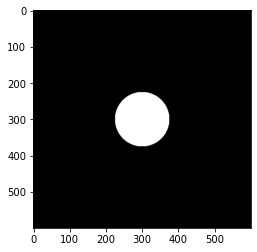

In [12]:
img_shape = img_gray.shape
print(img_shape)
#INSERT CODE HERE
nu_0 = 1/(2*delta)
f_hat = ideal_low_pass_filter(img_shape,nu_0)
plt.imshow(f_hat,cmap='gray')

Carry out the filtering, and subsample the image again, and imwrite the result.

You should observe that the range of the image is not respected. Make sure to rescale the output image to the range $0, \dots, 1$ before writing it.

__Question 1.4__ Why do you think this happens ?

<div class="alert alert-block alert-success">
    Answer :
This happens because of the convolution with the filter. 
We need to rescale the output image after.


In [13]:
img_filtered = filter_image(img_gray,f_hat)

img_filtered = (img_filtered-img_filtered.min())/(img_filtered.max()-img_filtered.min()) # normalize image

img_filtered = nn_subsampling(img_filtered,delta)


write_image(img_filtered,file_name+'_filtered_ideal_low_pass.png')

__Question 1.5__ Is the aliasing reduced ? What effect do you notice in the output ? What is this called ?


<div class="alert alert-block alert-success">
    Answer:


We can see on the structure of the House that the aliasing is definitively reduced. 
However, we notice in the output the introduction of ringin artefacts, near edges.
I think this is due to the low pass filter which corresponds to a convolution with a sinc signals who have oscillations.

Now, we are going to carry out the filtering with a Gaussian filter. Create a function ``gaussian_filter`` which returns a 2D Gaussian filter, defined as :

$g_\sigma(x,y) = \frac{1}{2 \pi \sigma^2} \exp{ \left( - \frac{x^2+y^x}{2\sigma^2} \right)}$

To create a grid of pixel positions, you can use the ``np.meshgrid`` function.

You must again make sure to carry out an ``ifftshift`` to make sure the filter is in the correct format. Be careful to put the middle of the Gaussian at the centre position ($a$).

In [14]:
def gaussian_filter(img_shape,sigma):
    #INSERT CODE HERE
    n = img_shape[0]
    x, y = np.meshgrid(np.linspace(-1,1,n), np.linspace(-1,1,n))
    g = np.exp(-( np.sqrt(x*x+y*y)**2 / ( 2.0 *sigma**2 ) ) )/ (2.0*np.pi*sigma**2)
    return g

Now, create a Gaussian filter in the frequency domain to attenuate the frequencies higher than the previous cutoff frequency you used above, $\nu_0$. To do this, we recall that 95.45 percent of the energy of a Gaussian function is contained within $\pm 2\sigma$. Fix $\sigma$ accordingly. Display the filter.

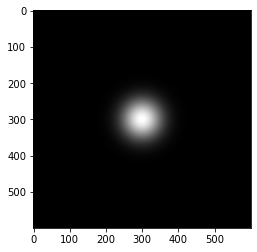

In [15]:
#INSERT CODE HERE
sigma = nu_0/2
g_hat = gaussian_filter(img_gray.shape,sigma)
plt.imshow(g_hat,cmap='gray')

Now, carry out the filtering with the Gaussian filter in the frequency domain. Remember to rescale the output image.

In [16]:
#INSERT CODE HERE
img_filtered = filter_image(img_gray,g_hat)

img_filtered = (img_filtered-img_filtered.min())/(img_filtered.max()-img_filtered.min()) # normalize image

img_filtered = nn_subsampling(img_filtered,delta)

write_image(img_filtered,file_name+'_filtered_gaussian.png')

__Question 1.6__ Do you still observe the problem observed in the case of the ideal low-pass filter ? Why ?

<div class="alert alert-block alert-success">
    Answer:

In this case, we don't have the problem observed in the case of the ideal low-pass filter, the convolution is done with a "better" filter (the gaussian one) because is doesn't have the oscillations.

__Question 1.7__ We have had to rescale the output image again. This time, why was this the case ? Hint : think about a Gaussian filter in the spatial domain with a very large $\sigma$.

<div class="alert alert-block alert-success">
    Answer :

The case in this situation is that with the Gaussian filter depending of the value of sigma squarred, because we multiply by positiv values and it could be very high depending of the sigma value.

## Standard filters

In this section, we are going to look at some common filters, and see their effects on images. From this point on in the TP, we are going to be working in the spatial domain, and are no longer concentrated on aliasing. Therefore, we can use the plt.imshow function (you may notice some aliasing, but we ignore it here). We define a display function now.

In [17]:
def display_image(img_in):
    plt.imshow(img_in,cmap='gray')

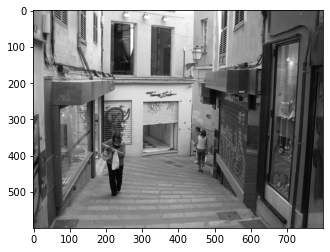

In [18]:
file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'

if (is_colab == True):
  !wget "https://perso.telecom-paristech.fr/anewson/doc/images/palma.png"
  img_gray,_ = read_image(file_name+file_ext)
else:
  img_gray,_ = read_image(file_dir+file_name+file_ext)
img_gray.shape

display_image(img_gray)

Now, write a function ``filter_image_spatial`` which carries out the 2D convolution between two images in the spatial domain. For this, you can use the ``convolve2d`` from the scipy.signal package. In this convolution, you should use the following parameters :

- mode='same'. This means that the output size of the image will be the same as the input
- boundary='symm'. For values outside the image domain, we take the symmetrical values of the image

Strictly speaking, if we take the Fourier transform of an image, we are using periodic boudary conditions. However, at this point we no longer need the frequency representation of the image, so we can define the conditions as we wish.

In [19]:
def filter_image_spatial(img,f):
    #INSERT CODE HERE
    img_out = signal.convolve2d(img, f, mode="same", boundary='symm')
    return(img_out)

Now, define the filters grad_y and grad_x which give the derivatives of the image in the $y$ and $x$ directions, resepctively (see lesson slides). Note : you must define these filters in the spatial domain, and make sure that they are matrices (otherwise the dimensions will not match with those of the image);

In [20]:
#INSERT CODE HERE
grad_x = np.array([[-1,1]])
grad_y = np.array([[-1],[1]]) 

In [21]:
grad_x

array([[-1,  1]])

In [22]:
grad_y

array([[-1],
       [ 1]])

Filter the input image and display the results of these two filterings

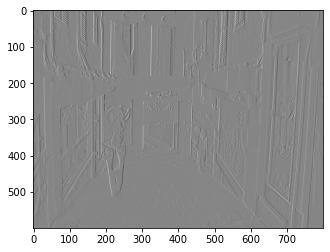

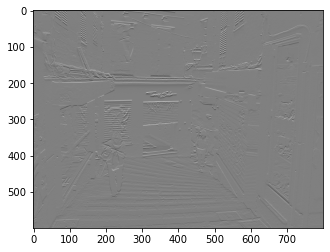

In [23]:
#INSERT CODE HERE
img_grad_x = filter_image_spatial(img_gray,grad_x)
img_grad_y = filter_image_spatial(img_gray,grad_y)

display_image(img_grad_x)
plt.figure()
display_image(img_grad_y)

Suppose we wish to create a sketch of our image, with just the outlines of object. Propose a (simple) method to create a binary image where the edges are shown. Implement this in a function called ``sketch_image``, and apply it to the input image. Display it (you can write it as well to view it better).

C:\Users\reppe\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


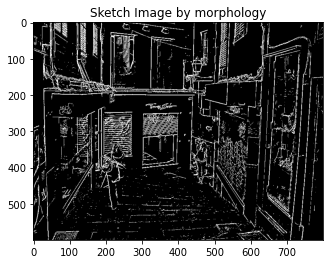

In [24]:
def sketch_image(img_in,tau):
    
    img_out = np.logical_or(img_grad_x>tau,img_grad_y>tau).astype(np.float)
    return img_out

tau = 0.05
img_sketch = sketch_image(img_gray,tau)
display_image(img_sketch)
plt.title('Sketch Image by morphology')
write_image(img_sketch, file_name+'_sketch.png')

Depending on the threshold used in your algorithm, the sketch may have a certain thickness. Ideally, we would like to have a sketch of one-pixel thickness. This is something we would like to avoid in the sketch. Propose a solution (using the information in the lesson) to this using morphological operators, and implement it. You can find the necessary function in the following package (do not reimplement this operation, there is alread a function which exists) :

- skimage.morphology

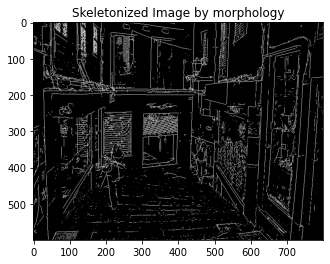

In [25]:
def filter_image_skeletonise(img):
    img_out = skeletonize(img)
    return(img_out)

img_skeletonized=filter_image_skeletonise(img_sketch)
display_image(img_skeletonized)
plt.title('Skeletonized Image by morphology')
write_image(img_skeletonized, file_name+'_skeletonized.png')


<div class="alert alert-block alert-success">
    Here, we have the one-pixel thickness thanks to the skimage.morphology library.
(I wrote those images in order to this the results better, which are really visible outside of this jupyter display)